In [1]:
import folium
from folium import Map, Circle
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import warnings
warnings.filterwarnings('ignore')

ruta='/Users/nico/Desktop/Data Science/TFM/Energy Forecast/Datos Pablo/'
client=pd.read_csv(ruta+'client.csv')
elec=pd.read_csv(ruta+'electricity_prices.csv')
gas=pd.read_csv(ruta+'gas_prices.csv')
train=pd.read_csv(ruta+'train.csv')
prediccion=pd.read_csv(ruta+'forecast_weather.csv')
clima=pd.read_csv(ruta+'historical_weather.csv')
ubicaciones_n=pd.read_csv(ruta+'county_lon_lats.csv')
ubicaciones=pd.read_csv(ruta+'weather_station_to_county_mapping.csv')
trainn=train

## 0-0. Función para obtener los usuarios que hay en cada uno de los cantones junto con el número de veces que han sido trackeados


In [2]:
def usuarios_unicos_canton (train, canton):
    usuarios=train[train['county']==canton].prediction_unit_id.unique()
    print('Hay', len(usuarios),'usuarios únicos en el cantón número', canton,':', usuarios)
    print()
    for i in usuarios:
        print('El usuario', i, 'fue trackeado en las siguientes fechas:')
        print(train[train['prediction_unit_id']==i].datetime.unique())
        print()
    return usuarios

## 0-1. Función para obtener los usuarios que hay con cada tipo de contrato junto con el número de veces que han sido trackeados


In [3]:
def usuarios_unicos_contrato (train, contrato):
    usuarios=train[train['product_type']==contrato].prediction_unit_id.unique()
    print('Hay', len(usuarios),'usuarios únicos con contrato tipo', contrato,':', usuarios)
    print()
    for i in usuarios:
        print('El usuario', i, 'fue trackeado en las siguientes fechas:')
        print(train[train['prediction_unit_id']==i].datetime.unique())
        print()
    return usuarios

## 1. Relación entre fechas y consumo/producción de los distintos usuarios en los distintos cantones 

In [4]:
'''Esta función grafica el consumo/producción electrica en función del tiemo. Los argumentos de entrada
son el dataset principal, el número id de usuario y un valor booleano (1 o 0) de consumo(1) o producción(0).
Es importante acordarase de que las fechas DEBEN IR EN FORMATO FECHA'''
def grafica_energia_fechas(train, usuario, consumo):
    df=train[train['is_consumption']==consumo]
    df['datetime'] = pd.to_datetime(df['datetime'])
    x=df[df['prediction_unit_id']==usuario].datetime
    y=df[df['prediction_unit_id']==usuario].target
    plt.figure(figsize=(8, 6))  # Configura el tamaño del gráfico
    plt.plot(x, y, linestyle='-')
    if consumo==1:
        plt.title(f'Consumo frente a Fecha del Usuario {usuario}')  # Título del gráfico
        plt.xlabel('Fecha')  # Etiqueta del eje x
        plt.ylabel('Consumo (mWh)')  # Etiqueta del eje y
    else:
        plt.title(f'Producción frente a Fecha del Usuario {usuario}')  # Título del gráfico
        plt.xlabel('Fecha')  # Etiqueta del eje x
        plt.ylabel('Producción (mWh)')  # Etiqueta del eje y
    plt.show()

## 2. Relación entre horas y consumo/producción

In [5]:
def grafica_energia_hora(train, usuario, consumo):
    train['datetime'] = pd.to_datetime(train['datetime'])
    df=train[train['is_consumption']==consumo]
    df=df[df['prediction_unit_id']==usuario]
    df['hour']=df['datetime'].dt.hour
    x=df.groupby(['hour'])['target'].mean()
    
    #Ahora grafico el consumo/producción medio por hora del usuario en cuestión
    plt.figure(figsize=(8, 4))
    x.plot(kind='bar')
    plt.xlabel('Hora del Día')
    if consumo==1:
        plt.title(f'Promedio de Consumo por Hora del Día Usuario {usuario}')
        plt.ylabel('Consumo Promedio')
    else:
        plt.title(f'Promedio de Producción por Hora del Día Usuario {usuario}')
        plt.ylabel('Producción Promedia')
    plt.grid(True)
    plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor visualización
    plt.tight_layout()
    plt.show()
    return 



## 3. Relación entre consumo/producción y día de la semana

In [6]:
def grafica_energia_dia_semana(train, usuario, consumo):
    train['datetime'] = pd.to_datetime(train['datetime'])
    train['week_day'] = train['datetime'].dt.day_name()
    df=train[train['is_consumption']==consumo]
    df=df[df['prediction_unit_id']==usuario]
    plt.figure(figsize=(8, 4))
    x=df.groupby(['week_day'])['target'].mean()
    x.plot(kind='bar')
    plt.xlabel('Día de la semana')
    if consumo==1:
        plt.title(f'Promedio de Consumo por Día de la Semana del Usuario {usuario}')
        plt.ylabel('Consumo Promedio')
    else:
        plt.title(f'Promedio de Producción por Día de la Semana del Usuario {usuario}')
        plt.ylabel('Producción Promedia')
    plt.grid(True)
    plt.xticks(rotation=0)  
    plt.tight_layout()
    plt.show()
    return


## RESUMEN FINAL DE LAS GRÁFICAS

In [7]:
'''Esta función es un resumen del cantón, donde se podrán ver el tipo concreto de gráfica de cada uno de los usuarios
pertenecientes al cantón seleccionado'''
def resumen_canton(train, tipo, canton, consumo):
    usuarios=usuarios_unicos_canton(train, canton)
    rango=len(usuarios)
    for i in range(rango):
        if tipo=='fecha':
            grafica_energia_fechas(train, usuarios[i], consumo)
        elif tipo=='hora':
            grafica_energia_hora(train, usuarios[i], consumo)
        elif tipo=='dia':
            grafica_energia_dia_semana(train, usuarios[i], consumo)

In [8]:
'''Tenemos 4 tipos de contrato:
{0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}
Valores de entrada: 
train: dataset con los datos
tipo: tipo de gráfica que se quiere usar
contrato: tipo de contrato (0, 1, 2 ó 3)
consumo: booleano (0 ó 1) indicando si es consumo o no
'''
def resumen_contrato(train, tipo, contrato, consumo):
    usuarios=usuarios_unicos_contrato(train, contrato)
    rango=len(usuarios)
    for i in range(rango):
        if tipo=='fecha':
            grafica_energia_fechas(train, usuarios[i], consumo)
        elif tipo=='hora':
            grafica_energia_hora(train, usuarios[i], consumo)
        elif tipo=='dia':
            grafica_energia_dia_semana(train, usuarios[i], consumo)

Hay 3 usuarios únicos en el cantón número 1 : [6 7 8]

El usuario 6 fue trackeado en las siguientes fechas:
['2021-09-01 00:00:00' '2021-09-01 01:00:00' '2021-09-01 02:00:00' ...
 '2023-05-31 21:00:00' '2023-05-31 22:00:00' '2023-05-31 23:00:00']

El usuario 7 fue trackeado en las siguientes fechas:
['2021-09-01 00:00:00' '2021-09-01 01:00:00' '2021-09-01 02:00:00' ...
 '2023-05-31 21:00:00' '2023-05-31 22:00:00' '2023-05-31 23:00:00']

El usuario 8 fue trackeado en las siguientes fechas:
['2021-09-01 00:00:00' '2021-09-01 01:00:00' '2021-09-01 02:00:00' ...
 '2023-05-31 21:00:00' '2023-05-31 22:00:00' '2023-05-31 23:00:00']



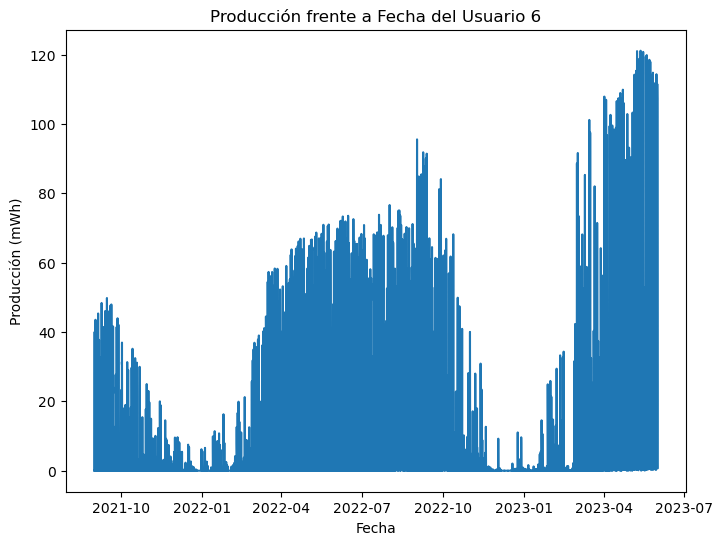

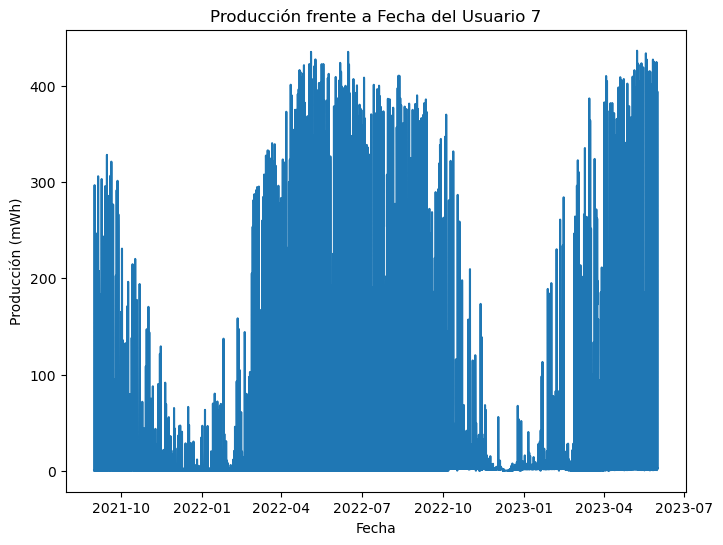

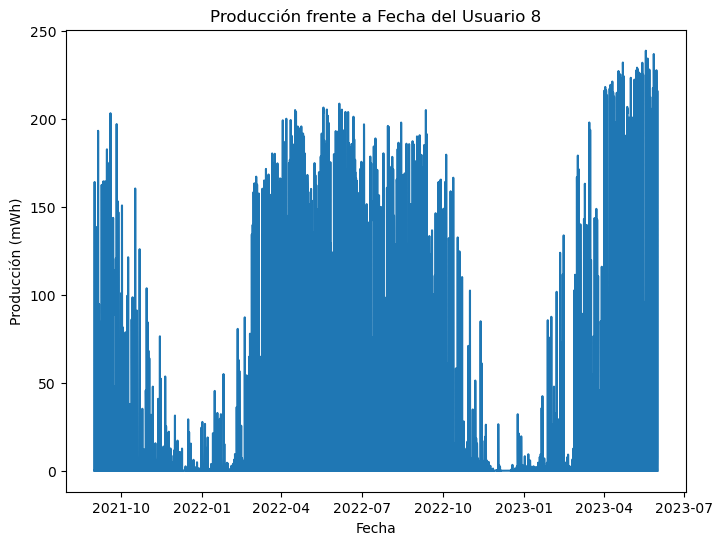

In [9]:
resumen_canton(train, 'fecha', 1, 0)